# DSCI 417 – Project 02 Instructions
## Student Grade Database
**Lauren Forti**

## Part A: Set up Environment
Setup the environment, beginning with import statements.

In [0]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, expr

# create instance of SparkSession
spark = SparkSession.builder.getOrCreate()

## Part B: Load the Data
Import each data file into a Spark DataFrame and print the number of records in each.

In [0]:
# read accepted file into df
accepted = (
    spark.read
    .option('delimiter', ',')
    .option('header', True)
    .schema('acc_term_id STRING, sid INTEGER, first_name STRING, last_name STRING, major STRING')
    .csv('/FileStore/tables/univ/accepted.csv')
)

# read alumni file into df
alumni = (
    spark.read
    .option('delimiter', ',')
    .option('header', True)
    .schema('sid INTEGER')
    .csv('/FileStore/tables/univ/alumni.csv')
)

# read expelled file into df
expelled = (
    spark.read
    .option('delimiter', ',')
    .option('header', True)
    .schema('sid INTEGER')
    .csv('/FileStore/tables/univ/expelled.csv')
)

# read unretained file into df
unretained = (
    spark.read
    .option('delimiter', ',')
    .option('header', True)
    .schema('sid INTEGER')
    .csv('/FileStore/tables/univ/unretained.csv')
)

# read faculty file into df
faculty = (
    spark.read
    .option('delimiter', ',')
    .option('header', True)
    .schema('fid INTEGER, first_name STRING, last_name STRING, dept STRING')
    .csv('/FileStore/tables/univ/faculty.csv')
)

# read courses file into df
courses = (
    spark.read
    .option('delimiter', ',')
    .option('header', True)
    .schema('dept STRING, course STRING, prereq STRING, credits INTEGER')
    .csv('/FileStore/tables/univ/courses.csv')
)

# read grades file into df
grades = (
    spark.read
    .option('delimiter', ',')
    .option('header', True)
    .schema('term_id STRING, course STRING, sid INTEGER, fid INTEGER, grade STRING')
    .csv('/FileStore/tables/univ/grades.csv')
)

Print the number of records in each DataFrame.

In [0]:
# output the number of records in the dfs
print(f'The number of records in accepted is {str(accepted.count())}.')
print(f'The number of records in alumni is {str(alumni.count())}.')
print(f'The number of records in expelled is {str(expelled.count())}.')
print(f'The number of records in unretained is {str(unretained.count())}.')
print(f'The number of records in faculty is {str(faculty.count())}.')
print(f'The number of records in courses is {str(courses.count())}.')
print(f'The number of records in grades is {str(grades.count())}.')

The number of records in accepted is 12207.
The number of records in alumni is 4920.
The number of records in expelled is 403.
The number of records in unretained is 2289.
The number of records in faculty is 330.
The number of records in courses is 119.
The number of records in grades is 285137.

## Part C: Student Count by Status
Count the number of students who have been accepted, students who actually enrolled in courses, current students, all former students, alumni, unretained students, and students who were expelled.

In [0]:
# create df of enrolled students
enrolled = (
  accepted
  # bring in grade info
  .join(other=grades, on='sid', how='semi')
)

# create df of current students
current = (
  enrolled
  # filter out alumni
  .join(other=alumni, on='sid', how='anti')
  # filter out unretained students
  .join(other=unretained, on='sid', how='anti')
  # filter out expelled students
  .join(other=expelled, on='sid', how='anti')
)

# create df of former students
former = (
  enrolled
  # filter out current students
  .join(other=current, on='sid', how='anti')
)

# display student counts
print(f'Number of accepted students:    {str(accepted.count())}')
print(f'Number of enrolled students:    {str(enrolled.count())}')
print(f'Number of current students:     {str(current.count())}')
print(f'Number of former students:      {str(former.count())}')
print(f'Number of unretained students:  {str(unretained.count())}')
print(f'Number of expelled students:    {str(expelled.count())}')
print(f'Number of alumni:               {str(alumni.count())}')

Number of accepted students: 12207
Number of enrolled students: 9667
Number of current students: 2055
Number of former students: 7612
Number of unretained students: 2289
Number of expelled students: 403
Number of alumni: 4920

## Part D: Distribution of Students by Major
Determine of the number of students currently in each major and the proportion of the overall number of students in each major.

In [0]:
# store # of current students
num_students = current.count()

(
  current
  
  # group according to major
  .groupBy('major')
  
  # get # of students per major
  .agg(
    expr('count(major) as n_students')
  )
  
  # calc proportion of students per major
 .select(
    '*',
    (col('n_students')/num_students*100).alias('prop')
  )
  
  # round results
  .select(
    'major', 
    'n_students',
    expr('round(prop,4) as prop')
  )
  
  # sort desc by prop
  .sort('prop', ascending = False)
).show()

+-----+----------+-------+
major|n_students| prop|
+-----+----------+-------+
 BIO| 615| 29.927|
 CSC| 508|24.7202|
 CHM| 405| 19.708|
 MTH| 320|15.5718|
 PHY| 207| 10.073|
+-----+----------+-------+

## Part E: Course Enrollments by Department
Determine the number of students enrolled in courses offered by each department during the Spring 2021 term.

In [0]:
# get # of students during spring 2021 term
sp21_enr = grades.filter(col('term_id') == '2021A').count()

sp21_grades = (
  grades
  # keep only grades from spring 2021
  .filter(col('term_id') == '2021A')
  
  # bring in course info
  .join(other=courses, on='course', how='inner')
  
  # group data by dept
  .groupBy('dept')
  
  # get count of students per dept
  .agg(
    expr('count(dept) as n_students')
  )

  # calc proportion of students per major
 .select(
    '*',
    (col('n_students')/sp21_enr*100).alias('prop')
  )
  
  # round results
  .select(
    'dept', 
    'n_students',
    expr('round(prop,4) as prop')
  )  
  
  # sort desc by prop
  .sort('prop', ascending = False)
)

# display df
sp21_grades.show()

+----+----------+-------+
dept|n_students| prop|
+----+----------+-------+
 GEN| 5142|41.9755|
 BIO| 1786|14.5796|
 MTH| 1517|12.3837|
 CHM| 1512|12.3429|
 CSC| 1479|12.0735|
 PHY| 814| 6.6449|
+----+----------+-------+

## Part F: Graduation Rates by Major
Determine the graduation rates for each major. Start by creating a DataFrame with the number of former students in each major.

In [0]:
# get # of former students by major
former_by_major = (
  former
  
  # group data by dept
  .groupBy('major')
  
  # get count of students per dept
  .agg(
    expr('count(major) as n_former')
  )

  # sort by major
  .sort('major')
)

# display df
former_by_major.show()

+-----+--------+
major|n_former|
+-----+--------+
 BIO| 2243|
 CHM| 1527|
 CSC| 1940|
 MTH| 1139|
 PHY| 763|
+-----+--------+

Determine the number of alumni for each major.

In [0]:
# get # of alumni students by major
alumni_by_major = (
  former
  
  # bring in major info
  .join(other=alumni, on='sid', how='inner')
  
  # group data by dept
  .groupBy('major')
  
  # get count of students per dept
  .agg(
    expr('count(major) as n_alumni')
  )

  # sort by major
  .sort('major')
)

# display df
alumni_by_major.show()

+-----+--------+
major|n_alumni|
+-----+--------+
 BIO| 1485|
 CHM| 1017|
 CSC| 1231|
 MTH| 723|
 PHY| 464|
+-----+--------+

Determine the graduation rates based on the former students and alumni data.

In [0]:
grad = (
  former_by_major
  
  # add alumni by major info
  .join(other=alumni_by_major, on='major', how='inner')
  
  # calc grad rate
  .select(
    '*',
    expr('round(n_alumni/n_former*100,4) as grad_rate')
  )
  
  # round results
  .select('major', 'n_alumni', 'n_former', 'grad_rate')  
  
  # sort by major
  .sort('major')
).show()

+-----+--------+--------+---------+
major|n_alumni|n_former|grad_rate|
+-----+--------+--------+---------+
 BIO| 1485| 2243| 66.206|
 CHM| 1017| 1527| 66.6012|
 CSC| 1231| 1940| 63.4536|
 MTH| 723| 1139| 63.4767|
 PHY| 464| 763| 60.8126|
+-----+--------+--------+---------+

## Part G: Number of Terms Required for Graduation
Find a frequency distribution for the number of terms that alumni required for graduation.

In [0]:
(
  grades
  
  # keep only records in alumni too
  .join(other=alumni, on='sid', how='semi')
  
  # group by sid
  .groupBy('sid')
  
  # count # of distinct values of term_id for each alumnus
  .agg(
    expr('count(distinct(term_id)) as n_terms')
  )
  
  # group by terms for each alumnus
  .groupBy('n_terms')
  
  # count # of records w/ each value of n_terms
  .agg(
    expr('count(n_terms) as n_alumni')
  )
  
  # sort by term #s
  .sort('n_terms')
  
).show()

+-------+--------+
n_terms|n_alumni|
+-------+--------+
 7| 200|
 8| 3045|
 9| 1203|
 10| 241|
 11| 121|
 12| 46|
 13| 32|
 14| 14|
 15| 7|
 16| 7|
 17| 2|
 18| 1|
 25| 1|
+-------+--------+

## Part H: Current Student GPA
Calculate the GPA of each current student and analyze the results. Start by creating a function to convert letter grades to numerical grades.

In [0]:
# function to convert letter -> numeric grade
def convert_grades(letter):
  letter_grades = {
    'A':4,
    'B':3,
    'C':2,
    'D':1,
    'F':0
  }
  # return appropriate grade
  return letter_grades.get(letter)

# register as Spark UDF
spark.udf.register('convert_grades', convert_grades)

Out[11]: <function __main__.convert_grades(letter)>

Calculate the GPA of each student currently enrolled.

In [0]:
current_gpa = (
  grades
  
  # bring in course info
  .join(other=courses, on='course', how='inner')
  
  # add col of numeric grades
  .select(
    '*',
    expr('convert_grades(grade) as num_grade')
  )
  
  # add col of gp
  .select(
    '*',
    expr('credits * num_grade as gp')
  )
  
  # group by sid
  .groupBy('sid')
  
  # sum gp and credits
  .agg(
    expr('sum(gp) as gp'),
    expr('sum(credits) as credits')
  )
  
  # calc gpa
  .select(
    '*',
    expr('round(gp/credits,2) as gpa')
  )
  
  # bring in current student info
  .join(other=current, on='sid', how='inner')
  
  # select specific cols
  .select(
    'sid',
    'first_name',
    'last_name',
    'major',
    'gpa'
  )
  
  # sort by gpa
  .sort('gpa')
)

# display first 10 elements of df
current_gpa.show(10)

+------+----------+---------+-----+----+
 sid|first_name|last_name|major| gpa|
+------+----------+---------+-----+----+
111582| Amy|Alexander| CHM|0.29|
111316| Harold| Mitchell| BIO|0.45|
111120| Lawrence| Sullivan| BIO|0.54|
111084| Emma| Ortiz| PHY|0.57|
111008| Wayne| Coleman| CSC| 0.6|
111947| Peter| Crawford| CSC| 0.6|
112082| Barbara| Thompson| PHY| 0.6|
111250| Margaret| Butler| PHY|0.62|
111909| Christine| Gomez| BIO|0.65|
111258| Alice| Butler| BIO|0.66|
+------+----------+---------+-----+----+
only showing top 10 rows

Determine the number of current students with 4.0 GPAs.

In [0]:
perfect_gpa = current_gpa.select('*').filter(col('gpa') == 4.0).count()
print(f'Number of current students with perfect 4.0 GPAs: {perfect_gpa}')

Number of current students with perfect 4.0 GPAs: 95

Create a histogram displaying the distribution of GPAs for current students.

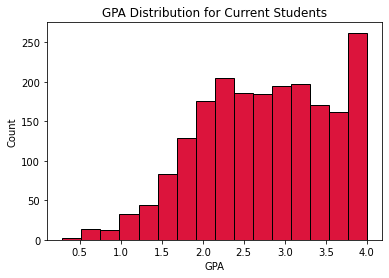

In [0]:
# convert df to pandas df
current_gpa = current_gpa.toPandas()

# create histogram
plt.hist(
  current_gpa.gpa,
  bins = 16,
  color='crimson',
  edgecolor='k'
)

# add labels
plt.xlabel('GPA')
plt.ylabel('Count')
plt.title('GPA Distribution for Current Students')

# show histogram
plt.show()

## Part I: Grade Distribution by Instructor
Determine the proportion of A, B, C, D, and F grades given out by each faculty member. Start by determing the distribution of the grades awarded by each faculty member.

In [0]:
faculty_grade_dist = (
  grades
  
  # group by faculty id
  .groupBy('fid')

  .agg(
    # get faculty dist
    expr('count(fid) as N'),
    
    # get grade counts
    expr('SUM(CASE WHEN grade == "A" THEN 1 ELSE 0 END) AS countA'),
    expr('SUM(CASE WHEN grade == "B" THEN 1 ELSE 0 END) AS countB'),
    expr('SUM(CASE WHEN grade == "C" THEN 1 ELSE 0 END) AS countC'),
    expr('SUM(CASE WHEN grade == "D" THEN 1 ELSE 0 END) AS countD'),
    expr('SUM(CASE WHEN grade == "F" THEN 1 ELSE 0 END) AS countF')
  )
  
  # bring in faculty info
  .join(other=faculty, on='fid', how='full')
  
  # select cols and calc grade dist
  .select(
    'fid', 'first_name', 'last_name', 'dept', 'N',
    expr('round(countA/N,2) as propA'),
    expr('round(countB/N,2) as propB'),
    expr('round(countC/N,2) as propC'),
    expr('round(countD/N,2) as propD'),
    expr('round(countF/N,2) as propF')
  ) 
)

# display first 5 records
faculty_grade_dist.show(5)

+----+----------+---------+----+----+-----+-----+-----+-----+-----+
 fid|first_name|last_name|dept| N|propA|propB|propC|propD|propF|
+----+----------+---------+----+----+-----+-----+-----+-----+-----+
1001| Jordan| Wright| PHY|1456| 0.23| 0.36| 0.31| 0.09| 0.01|
1002| David| Carter| CHM|2962| 0.21| 0.32| 0.36| 0.09| 0.01|
1003| Patrick|Henderson| PHY|2092| 0.12| 0.28| 0.4| 0.18| 0.02|
1004| Denise| Anderson| CSC|3194| 0.3| 0.39| 0.26| 0.05| 0.0|
1005| Jerry| Perry| MTH| 368| 0.44| 0.36| 0.15| 0.03| 0.01|
+----+----------+---------+----+----+-----+-----+-----+-----+-----+
only showing top 5 rows

Identify the 10 faculty members who assign the fewest "A" grades.

In [0]:
(
  faculty_grade_dist
  
  # filter out faculty w/ < 100 grades
  .filter(col('N') >= 100)
  
  # sort by prop of As
  .sort('propA')
  
).show(10)

+----+----------+---------+----+---+-----+-----+-----+-----+-----+
 fid|first_name|last_name|dept| N|propA|propB|propC|propD|propF|
+----+----------+---------+----+---+-----+-----+-----+-----+-----+
1628| Rebecca| Stewart| GEN|395| 0.03| 0.2| 0.37| 0.28| 0.12|
1481| Abigail| Brooks| BIO|311| 0.05| 0.23| 0.37| 0.28| 0.08|
3187| Joshua| Griffin| GEN|154| 0.05| 0.24| 0.38| 0.21| 0.12|
1264| Carol| Martin| CSC|302| 0.07| 0.22| 0.34| 0.25| 0.13|
1039| Joan| Lee| BIO|147| 0.07| 0.24| 0.31| 0.33| 0.05|
1479| Karen| Simmons| GEN|310| 0.08| 0.31| 0.3| 0.21| 0.1|
1212| Michael| Martinez| MTH|775| 0.09| 0.23| 0.31| 0.27| 0.11|
1591| Amanda| Mitchell| CHM|395| 0.09| 0.29| 0.35| 0.18| 0.08|
1462| Ralph| Perez| BIO|195| 0.09| 0.21| 0.39| 0.23| 0.09|
2925| Cynthia| Lewis| GEN|302| 0.09| 0.22| 0.35| 0.25| 0.09|
+----+----------+---------+----+---+-----+-----+-----+-----+-----+
only showing top 10 rows

Identify the 10 faculty members who assign the most "A" grades.

In [0]:
(
  faculty_grade_dist
  
  # filter out faculty w/ < 100 grades
  .filter(col('N') >= 100)
  
  # sort by prop of As desc
  .sort('propA', ascending=False)
  
).show(10)

+----+----------+---------+----+----+-----+-----+-----+-----+-----+
 fid|first_name|last_name|dept| N|propA|propB|propC|propD|propF|
+----+----------+---------+----+----+-----+-----+-----+-----+-----+
1092| Hannah| Morgan| GEN|1953| 0.59| 0.3| 0.09| 0.01| 0.0|
1262| Sara| Hunter| GEN|2266| 0.57| 0.28| 0.12| 0.02| 0.0|
1548| Donald| Gibson| GEN|1478| 0.55| 0.27| 0.14| 0.03| 0.01|
1094| Judy|Patterson| GEN|1904| 0.55| 0.32| 0.12| 0.02| 0.0|
1484| Billy| Cooper| BIO| 434| 0.54| 0.33| 0.09| 0.04| 0.01|
1328| David| Parker| GEN|1543| 0.53| 0.28| 0.14| 0.04| 0.01|
1058| John| Simpson| GEN|2729| 0.53| 0.33| 0.12| 0.02| 0.0|
1038| Theresa| Stevens| CHM| 233| 0.52| 0.31| 0.15| 0.02| 0.01|
1305| Betty| Stewart| GEN|2081| 0.51| 0.31| 0.14| 0.04| 0.01|
1291| Joyce| Butler| GEN|2212| 0.51| 0.31| 0.14| 0.03| 0.01|
+----+----------+---------+----+----+-----+-----+-----+-----+-----+
only showing top 10 rows

## Part J: First Term GPA
Calculate the first-term GPA for each student who has enrolled in classes.

In [0]:
first_term_gpa = (
  grades
  
  # bring in accepted students info
  .join(other=accepted, on='sid', how='full')
  
  # filter to keep records from first term
  .filter(col('term_id') == col('acc_term_id'))
  
  # bring in course info
  .join(other=courses, on='course', how='inner')
  
   # add col of numeric grades
  .select(
    '*',
    expr('convert_grades(grade) as num_grade')
  )
  
  # add col of gp
  .select(
    '*',
    expr('credits * num_grade as gp')
  )
  
  # group by sid
  .groupBy('sid')
  
  # sum gp and credits
  .agg(
    expr('sum(gp) as gp'),
    expr('sum(credits) as credits')
  )
  
  # calc gpa
  .select(
    '*',
    expr('round(gp/credits,2) as first_term_gpa')
  )

  # select specific cols
  .select(
    'sid',
    'first_term_gpa'
  )
  
  # sort by gpa
  .sort('first_term_gpa', ascending=False)
)

# display first 5 elements of df
first_term_gpa.show(5)

+------+--------------+
 sid|first_term_gpa|
+------+--------------+
106572| 4.0|
104224| 4.0|
101552| 4.0|
105979| 4.0|
103851| 4.0|
+------+--------------+
only showing top 5 rows

## Part K: Graduation Rates and First Term GPA
Calculate graduation rates for students whose first term GPA falls into each of four different grade ranges. Start by creating a function to determine which range a student's GPA falls into.

In [0]:
# function to determine which range a gpa falls into
def gpa_range(gpa):
  if gpa >= 0 and gpa < 1:
    return '[0,1)'
  elif gpa == 1 or gpa < 2:
    return '[1,2)'
  elif gpa == 2 or gpa < 3:
    return '[2,3)'
  else:
    return '[3,4]'

# register as Spark UDF
spark.udf.register('gpa_range', gpa_range)

Out[19]: <function __main__.gpa_range(gpa)>

Determine the number of alumni whose first-term GPA falls into each bin.

In [0]:
alumni_ft_gpa = (
  alumni
  
  # filter to keep only alumni
  .join(other=first_term_gpa, on='sid', how='inner')
  
   # add col of GPA range
  .select(
    '*',
    expr('gpa_range(first_term_gpa) as gpa_bin')
  )
  
  # groupy by GPA range
  .groupBy('gpa_bin')
  
  # count # in each group
  .agg(
    expr('count(sid) as n_alumni')
  )
  
  # sort by GPA range
  .sort('gpa_bin')
)

# display df
alumni_ft_gpa.show()

+-------+--------+
gpa_bin|n_alumni|
+-------+--------+
 [0,1)| 4|
 [1,2)| 549|
 [2,3)| 1887|
 [3,4]| 2480|
+-------+--------+

Determine the number of former students whose first-term GPA falls into each bin.

In [0]:
former_ft_gpa = (
  former
  
  # filter to keep only alumni
  .join(other=first_term_gpa, on='sid', how='inner')
  
   # add col of GPA range
  .select(
    '*',
    expr('gpa_range(first_term_gpa) as gpa_bin')
  )
  
  # groupy by GPA range
  .groupBy('gpa_bin')
  
  # count # in each group
  .agg(
    expr('count(sid) as n_former')
  )
  
  # sort by GPA range
  .sort('gpa_bin')
)

# display df
former_ft_gpa.show()

+-------+--------+
gpa_bin|n_former|
+-------+--------+
 [0,1)| 822|
 [1,2)| 1735|
 [2,3)| 2433|
 [3,4]| 2622|
+-------+--------+

Use the previous two DataFrames to determine the graduation rates for each of the GPA bins.

In [0]:
(
  alumni_ft_gpa
  
  # bring in former student GPA info
  .join(other=former_ft_gpa, on='gpa_bin', how='full')
  
  # calc grad rate
  .select(
    '*',
    expr('round(n_alumni/n_former,4) as grad_rate')
  )
  
  # sort by GPA range
  .sort('gpa_bin')
).show()

+-------+--------+--------+---------+
gpa_bin|n_alumni|n_former|grad_rate|
+-------+--------+--------+---------+
 [0,1)| 4| 822| 0.0049|
 [1,2)| 549| 1735| 0.3164|
 [2,3)| 1887| 2433| 0.7756|
 [3,4]| 2480| 2622| 0.9458|
+-------+--------+--------+---------+